In [1]:
# runup with variable slope
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'D:/crs/proj/2022_runup/'
fnames = ['hom_profiles.csv']

# from colorbrewer
oranges = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']

# load a profile
fname = fnames[0]
df=pd.read_csv(data_dir+fname,header = 0,delimiter=',')
df

,ID,X,Y,Elevation,Elevation (2020015FA_Truro_topobathy_1m.tif),Elevation (2021014FA_Truro_topobathy_1m.tif),Elevation (2022015FA_Truro_Topobathy_1m.tif),Distance (Segment),Distance (Total),Distance 3D (Segment),Distance 3D (Total),Slope (Degrees),Slope (Percent),Segment Index
0,1,410754.987,4656015.953,16.989,16.850,16.674,16.989,0.000,0.000,0.000,0.000,0.0,0.0,1
1,2,410755.424,4656016.639,16.946,16.895,16.687,16.946,0.813,0.813,0.814,0.814,3.0,5.2,1
2,3,410755.860,4656017.324,16.854,16.922,16.679,16.854,0.813,1.626,0.818,1.632,6.5,11.4,1
3,4,410756.297,4656018.009,16.783,16.929,16.644,16.783,0.813,2.438,0.816,2.448,5.0,8.7,1
4,5,410756.733,4656018.695,16.764,16.903,16.563,16.764,0.813,3.251,0.813,3.261,1.4,2.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1020,411199.746,4656714.365,-9.275,NaN,-9.453,-9.275,0.813,828.250,0.813,831.670,1.5,2.5,1
1020,1021,411200.182,4656715.051,-9.295,NaN,-9.470,-9.295,0.813,829.070,0.813,832.480,1.4,2.5,1
1021,1022,411200.619,4656715.736,-9.316,NaN,-9.487,-9.316,0.813,829.880,0.813,833.300,1.4,2.5,1
1022,1023,411201.055,4656716.422,-9.336,NaN,-9.505,-9.336,0.813,830.690,0.813,834.110,1.4,2.5,1


In [2]:
# extract data columns with convenient names
dist = df['Distance (Total)'].values
e2020 = df['Elevation (2020015FA_Truro_topobathy_1m.tif)'].values
e2021 = df['Elevation (2021014FA_Truro_topobathy_1m.tif)'].values
e2022 = df['Elevation (2022015FA_Truro_Topobathy_1m.tif)'].values

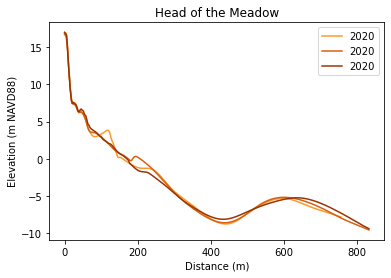

In [3]:
# plot the profiles
plt.plot(dist, e2020, label='2020', c = oranges[3])
plt.plot(dist, e2021, label='2021', c = oranges[4])
plt.plot(dist, e2022, label='2022', c = oranges[5])
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.title('Head of the Meadow')
_ = plt.legend()
#plt.savefig(data_dir+'hom_runup_profile.jpg', dpi=200, bbox_inches='tight')

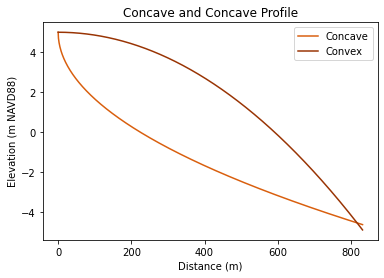

In [4]:
# make fake concave profile
econcave = -np.sqrt(dist)/3 + 5
# make fake convex profile
econvex = -dist**2 / 70000. +5.
plt.plot(dist, econcave, c = oranges[4], label='Concave')
plt.plot(dist, econvex, c = oranges[5], label='Convex')
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.legend()
_ = plt.title('Concave and Concave Profile')

In [5]:
def calc_L0(Tp = 10.):
    L0 = (9.81*Tp**2)/(2.*np.pi)
    return L0

def S06(H0 = 2., L0 = 156.131, Beta = 0.02):
    Ir = Beta/np.sqrt(H0/L0)
    S06_Setup = 0.35*Beta*np.sqrt(H0*L0)
    S06_Sinc = 0.75*Beta*np.sqrt(H0*L0)
    S06_Sig = 0.06*np.sqrt(H0*L0)
    S = np.sqrt(S06_Sinc**2+S06_Sig**2)
    R2 = 1.1*(S06_Setup+0.5*S)
    return R2

In [6]:
# list of the available profiles
prof_list = [econvex, econcave, e2020, e2021, e2022]

# list of starting water levels
wl_list = [0., .5, 1., 1.5]

In [7]:
# pick a profile
elev = e2020

# pick water level
wl = 0.5
Hs = 2.
Tp = 10.
L0 = calc_L0( Tp )



maxit = 7

for elev in prof_list:
    for wl in wl_list:
        
        # find indices and x, z for water level
        iwl = np.argwhere( elev <= wl)[0]
        ewl = elev[iwl]
        dwl = dist[iwl]
        # initialize arrays
        slope = np.nan*np.ones(maxit+1)
        R2 = np.ones_like( slope )
        eR2 = np.ones_like( slope )
        dR2 = np.ones_like( slope )

        # iterate - calcuate runup, find slope in that elevation range, re-calc runup...
        slope[0] = 0.05
        print( 'Slope    Runup   Elev   Change')
        for i in np.arange(maxit):
            R2[i] = S06( Hs, L0, slope[i] )
            eR2[i] = R2[i]+wl
            iR2 = np.argwhere( elev <= eR2[i])[0]
            dR2[i] = dist[iR2]
            iwl = np.argwhere( elev <= wl)[0]
            slope[i+1] = (eR2[i] - ewl)/(dwl - dR2[i])
            del_R2 = np.nan
            if i > 0:
                del_R2 = eR2[i]-eR2[i-1] 
            print('{:.3f}    {:.2f}    {:.2f}   {}'.format(slope[i], R2[i], eR2[i], del_R2))

        if np.abs( del_R2 ) <= 0.01:
            print('Converged')

Slope    Runup   Elev   Change
0.050    1.03    1.03   nan
0.016    0.70    0.70   -0.3239860920688715
0.016    0.71    0.71   0.0028798046913176556
0.016    0.71    0.71   0.0005527534904593567
0.016    0.71    0.71   0.00010614000575537297
0.016    0.71    0.71   2.038267097492774e-05
0.016    0.71    0.71   3.914260102377831e-06
Converged
Slope    Runup   Elev   Change
0.050    1.03    1.53   nan
0.015    0.70    1.20   -0.33125976839610893
0.015    0.70    1.20   0.0024051091296093396
0.015    0.70    1.20   0.00043258531028067537
0.016    0.70    1.20   7.783076368683695e-05
0.016    0.70    1.20   1.40041400902291e-05
0.016    0.70    1.20   2.5198008177795828e-06
Converged
Slope    Runup   Elev   Change
0.050    1.03    2.03   nan
0.014    0.69    1.69   -0.3388372387686016
0.015    0.69    1.69   0.003278561147611825
0.015    0.69    1.69   0.0005549832232807361
0.014    0.69    1.69   -0.001910679575665819
0.015    0.69    1.69   0.0016811429396919042
0.014    0.69    1.69   -

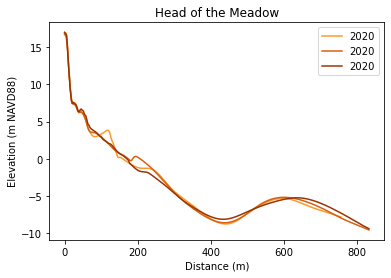

In [8]:
# plot
plt.plot(dist, e2020, label='2020', c = oranges[3])
plt.plot(dist, e2021, label='2021', c = oranges[4])
plt.plot(dist, e2022, label='2022', c = oranges[5])
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Distance (m)')
plt.title('Head of the Meadow')
_ = plt.legend()
#plt.savefig(data_dir+'hom_runup_profile.jpg', dpi=200, bbox_inches='tight')